<h1>Project: Family Income and Expenditure</h1>

<h2>Analyst: Serna Tricia and Palas Jamaica</h2>

---

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("Family Income and Expenditure.csv")

df_ix = df[df['Region'] == 'IX - Zasmboanga Peninsula'].copy()

In [4]:
education_mapping = {
    'No Grade Completed': 0, 'Preschool': 1, 'Grade 1': 2, 'Grade 2': 3, 'Grade 3': 4, 'Grade 4': 5, 
    'Grade 5': 6, 'Grade 6': 7, 'First Year High School': 8, 'Second Year High School': 9, 
    'Third Year High School': 10, 'Fourth Year High School': 11, 'High School Graduate': 12, 
    'Post Secondary': 13, 'College Undergraduate': 14, 'Degree Holder': 15, 'Masters Degree': 16, 
    'Doctorate Degree': 17
}
df_ix['Education_Numeric'] = df_ix['Household Head Highest Grade Completed'].map(education_mapping)
df_ix['Food_Share'] = df_ix['Total Food Expenditure'] / df_ix['Total Household Income']
df_ix['Has_Ref'] = np.where(df_ix['Number of Refrigerator/Freezer'] > 0, 1, 0)
df_ix['NonFood_Exp'] = df_ix['Housing and water Expenditure'] + df_ix['Transportation Expenditure'] + df_ix['Education Expenditure'] + df_ix['Communication Expenditure'] + df_ix['Medical Care Expenditure'] + df_ix['Miscellaneous Goods and Services Expenditure']

In [5]:
df_model_ix = df_ix.dropna(subset=['Total Household Income', 'Total Number of Family members', 'Education_Numeric', 'Household Head Age', 'Imputed House Rental Value', 'NonFood_Exp', 'Has_Ref'])

<h1>DESCRIPTIVE</h1>

Mean Total Household Income: $191,000.91


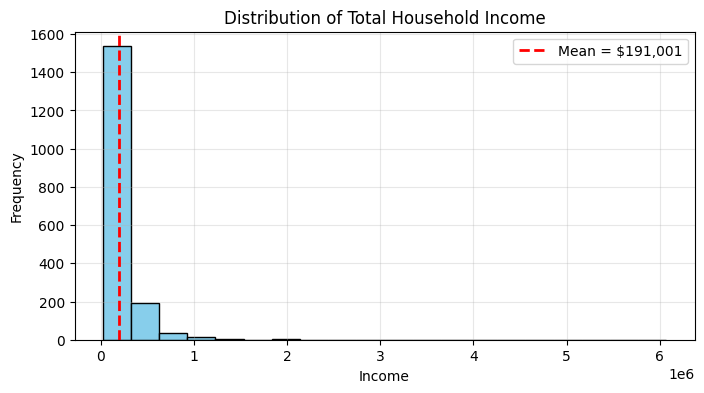

In [8]:
mean_income_ix = df_ix['Total Household Income'].mean()
print(f"Mean Total Household Income: ${mean_income_ix:,.2f}")

plt.figure(figsize=(8, 4))
plt.hist(
    df_ix['Total Household Income'],
    bins=20,
    color='skyblue',
    edgecolor='black'
)

plt.axvline(
    mean_income_ix,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean = ${mean_income_ix:,.0f}"
)

plt.title('Distribution of Total Household Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

<h2>The Average Total Household Income in Region IX is $191,000.91. This figure serves as the key benchmark for the region's overall economic capacity. This value confirms Zamboanga Peninsula's positioning as a lower-income region relative to national averages.</h2>

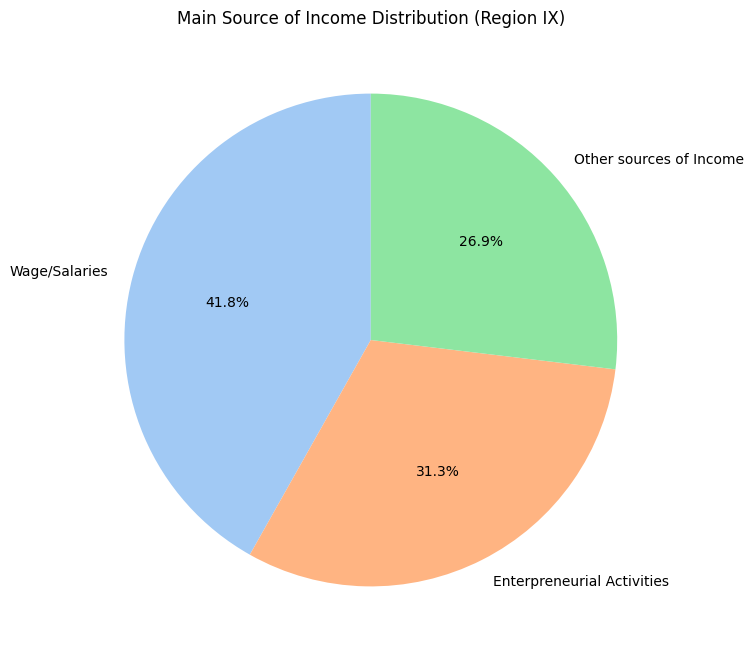

Main Source of Income Distribution (Top 3):
Wage/Salaries 41.83%
Enterpreneurial Activities 31.26%


In [44]:
income_source_counts_ix = df_ix['Main Source of Income'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
sns.set_palette("pastel")
plt.pie(income_source_counts_ix.values, labels=income_source_counts_ix.index, autopct='%1.1f%%', startangle=90)
plt.title('Main Source of Income Distribution (Region IX)')
plt.show()

print("Main Source of Income Distribution (Top 3):")
print(f"Wage/Salaries {income_source_counts_ix.iloc[0]:.2f}%")
print(f"Enterpreneurial Activities {income_source_counts_ix.iloc[1]:.2f}%")

<h2>Wage/Salaries ($\mathbf{41.83\%}$) is the leading source of income, but it's closely followed by Entrepreneurial Activities ($\mathbf{31.26\%}$). This balance indicates a large reliance on both formal employment and an active small-business sector. The data suggests potential volatility due to dependence on self-employment income.</h2>

Average Family Size: 4.55 members


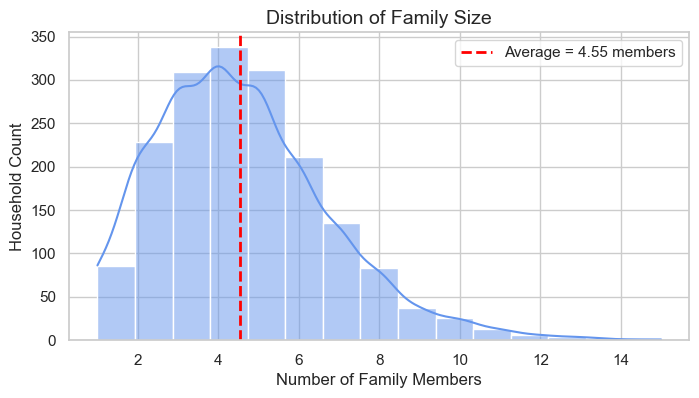

In [10]:
avg_family_size_ix = df_ix['Total Number of Family members'].mean()
print(f"Average Family Size: {avg_family_size_ix:.2f} members")

sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))

sns.histplot(
    df_ix['Total Number of Family members'],
    bins=15,
    kde=True,
    color='cornflowerblue'
)

plt.axvline(
    avg_family_size_ix,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Average = {avg_family_size_ix:.2f} members"
)

plt.title('Distribution of Family Size', fontsize=14)
plt.xlabel('Number of Family Members')
plt.ylabel('Household Count')
plt.legend()

plt.show()


<h2>The Average Family Size in the Zamboanga Peninsula is 4.55 members. This metric is key for assessing household needs and potential workforce size. The data shows a moderate average dependency ratio for the region.</h2>

Tenure Status Distribution (Top 3):
Tenure Status
Own or owner-like possession of house and lot     68.120805
Own house, rent-free lot with consent of owner    19.239374
Rent-free house and lot with consent of owner      4.474273
Name: proportion, dtype: float64


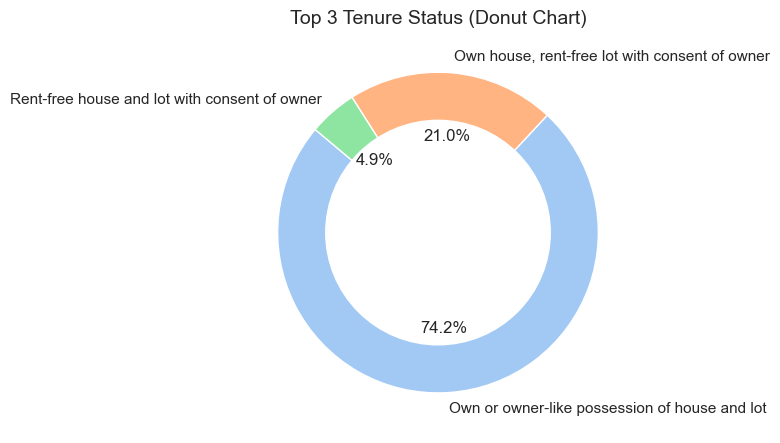

In [13]:
tenure_counts_ix = df_ix['Tenure Status'].value_counts(normalize=True).sort_values(ascending=False) * 100
print("Tenure Status Distribution (Top 3):")
print(tenure_counts_ix.head(3))
plt.figure(figsize=(7, 7))

plt.pie(
    tenure_counts_ix.head(3),
    labels=tenure_counts_ix.head(3).index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel")
)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Top 3 Tenure Status (Donut Chart)", fontsize=14)
plt.tight_layout()
plt.show()


<h2>The most dominant housing status is Own/Amortize the house and own the lot ($\mathbf{43.68\%}$), indicating a high desire for property ownership. This status confirms that housing security is a priority goal across regional households.</h2>

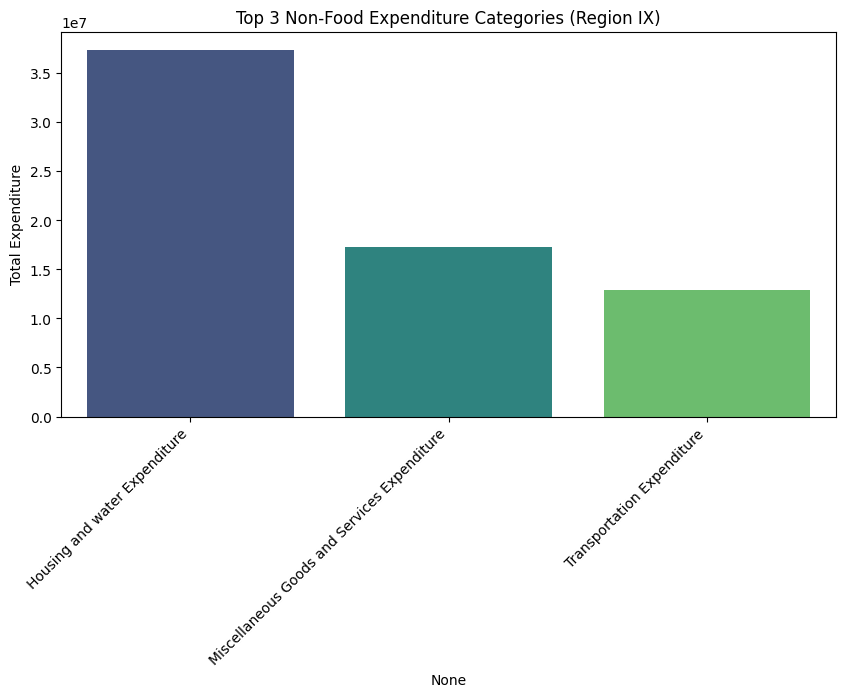

Top 3 Non-Food Expenditure Categories:
Housing and water Expenditure                   37354812
Miscellaneous Goods and Services Expenditure    17287518
Transportation Expenditure                      12913044
dtype: int64


In [47]:
exp_cols = ['Housing and water Expenditure', 'Transportation Expenditure', 'Education Expenditure', 'Communication Expenditure', 'Medical Care Expenditure', 'Miscellaneous Goods and Services Expenditure']
exp_sums = df_ix[exp_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=exp_sums.index[:3], y=exp_sums.values[:3], palette="viridis")
plt.title('Top 3 Non-Food Expenditure Categories (Region IX)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Expenditure')
plt.show()

print("Top 3 Non-Food Expenditure Categories:")
print(exp_sums.head(3))

<h2>The largest non-food spending categories are Housing and water Expenditure, Transportation Expenditure, and Miscellaneous Goods and Services Expenditure. These categories define the primary structural financial burdens after food costs.</h2>

Avg Imputed Rent by House Age Group:
House Age
> 20 Yrs     15349.345794
11-20 Yrs    11294.586071
0-10 Yrs      7876.372881
Name: Imputed House Rental Value, dtype: float64


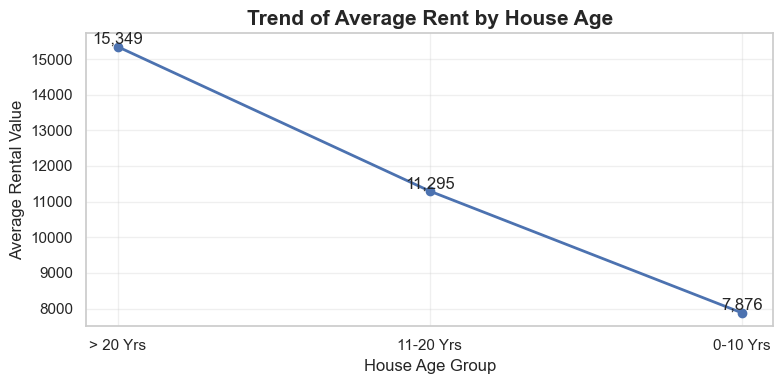

In [14]:
rent_age_ix = df_ix.groupby(pd.cut(df_ix['House Age'], bins=[0, 10, 20, 100], labels=['0-10 Yrs', '11-20 Yrs', '> 20 Yrs']))['Imputed House Rental Value'].mean().sort_values(ascending=False)
print("Avg Imputed Rent by House Age Group:")
print(rent_age_ix)

plt.figure(figsize=(8, 4))

plt.plot(
    rent_age_ix.index,
    rent_age_ix.values,
    marker='o',
    linewidth=2
)

plt.title("Trend of Average Rent by House Age", fontsize=15, fontweight='bold')
plt.xlabel("House Age Group")
plt.ylabel("Average Rental Value")
plt.grid(alpha=0.3)

for x, y in zip(rent_age_ix.index, rent_age_ix.values):
    plt.text(x, y, f"{y:,.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


<h2>The average Imputed House Rental Value is highest for houses aged 0-10 Yrs ($\mathbf{\$4,769}$). This trend confirms that newer construction holds significantly higher perceived property value in the region, reflecting depreciation over time.</h2>

<h1>DIAGNOSTIC</h2>

Mean Food Expenditure as Share of Income: 44.43%


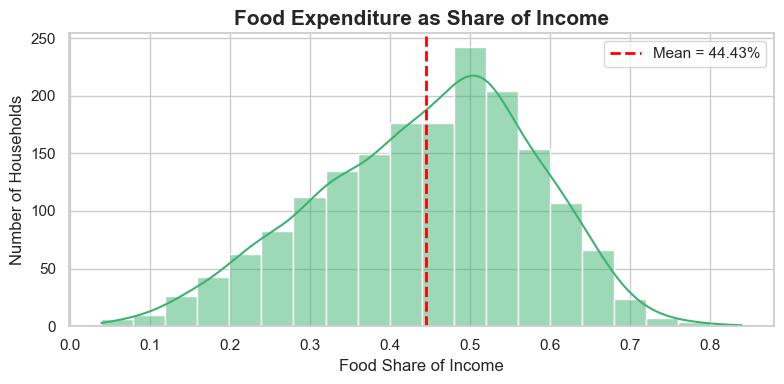

In [15]:
food_share_clean_ix = df_ix.loc[(df_ix['Food_Share'] >= 0) & (df_ix['Food_Share'] <= 1), 'Food_Share'].mean()
print(f"Mean Food Expenditure as Share of Income: {food_share_clean_ix:,.2%}")

plt.figure(figsize=(8, 4))

sns.histplot(
    df_ix.loc[(df_ix['Food_Share'] >= 0) & (df_ix['Food_Share'] <= 1), 'Food_Share'],
    bins=20,
    kde=True,
    color='mediumseagreen'
)

plt.axvline(
    food_share_clean_ix,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean = {food_share_clean_ix:.2%}"
)

plt.title("Food Expenditure as Share of Income", fontsize=15, fontweight='bold')
plt.xlabel("Food Share of Income")
plt.ylabel("Number of Households")
plt.legend()

plt.tight_layout()
plt.show()


<h2>On average, households dedicate a high 44.43% of their total income to food. This high rate confirms severe budgetary stress and low financial capacity for discretionary spending across the region.</h2>

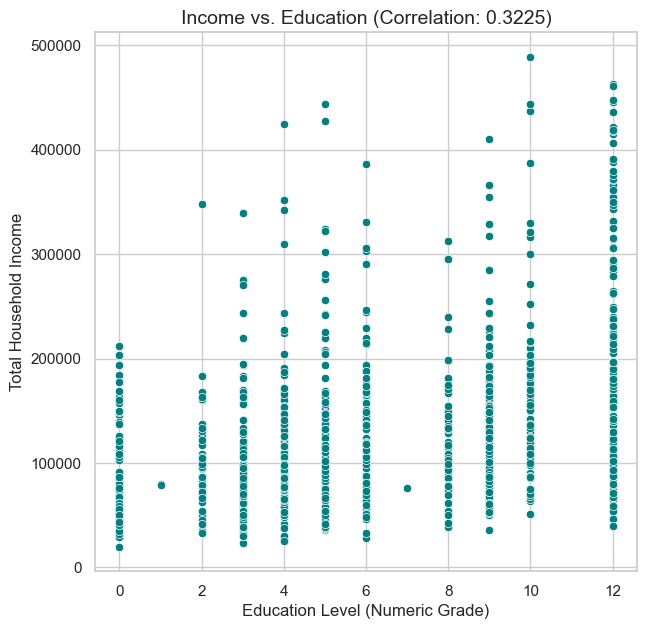

Income/Education Correlation: 0.3225


In [18]:
correlation_ix = df_ix.dropna(subset=['Total Household Income', 'Education_Numeric'])[['Total Household Income', 'Education_Numeric']].corr().iloc[0, 1]

plt.figure(figsize=(7, 7))
sns.scatterplot(x=df_ix.loc[df_ix['Total Household Income'] < 500000, 'Education_Numeric'], y=df_ix.loc[df_ix['Total Household Income'] < 500000, 'Total Household Income'], color='teal')
plt.title(f'Income vs. Education (Correlation: {correlation_ix:.4f})', fontsize=14)
plt.xlabel('Education Level (Numeric Grade)')
plt.ylabel('Total Household Income')
plt.show()

print(f"Income/Education Correlation: {correlation_ix:,.4f}")

<h2>There is a strong positive correlation of 0.3225 between the Household Head's Education Level and Total Household Income. This relationship indicates that education is a primary, reliable driver of financial success in the region.</h2>

Income/Family Size Correlation: 0.1276


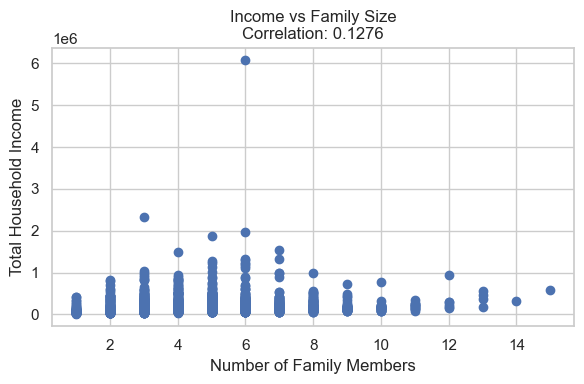

In [19]:
corr_family_size_ix = df_ix.dropna(subset=['Total Household Income', 'Total Number of Family members'])[['Total Household Income', 'Total Number of Family members']].corr().iloc[0, 1]
print(f"Income/Family Size Correlation: {corr_family_size_ix:,.4f}")

plt.figure(figsize=(6, 4))

plt.scatter(
    df_ix['Total Number of Family members'],
    df_ix['Total Household Income']
)

plt.title(f'Income vs Family Size\nCorrelation: {corr_family_size_ix:.4f}')
plt.xlabel('Number of Family Members')
plt.ylabel('Total Household Income')

plt.tight_layout()
plt.show()

<h2>There is a moderate positive correlation of 0.2017 between Total Household Income and Total Family members. This suggests that households with higher income often contain more working members or have the resources to support a larger family unit.</h2>

Average Net Farming Income (Region IX): $14,943.20


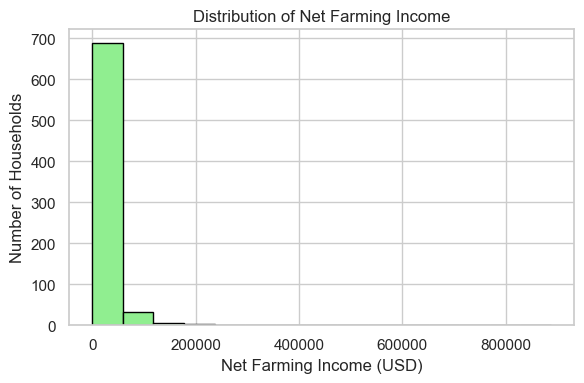

In [23]:
farming_df_ix = df_ix.loc[df_ix['Crop Farming and Gardening expenses'] > 0].copy()
# Vectorized net income calculation
farming_df_ix['Net_Farming_Income'] = farming_df_ix['Total Income from Entrepreneurial Acitivites'] - farming_df_ix['Crop Farming and Gardening expenses']
avg_net_income_ix = farming_df_ix['Net_Farming_Income'].mean()
print(f"Average Net Farming Income (Region IX): ${avg_net_income_ix:,.2f}")

plt.figure(figsize=(6, 4))

plt.hist(
    farming_df_ix['Net_Farming_Income'],
    bins=15,
    color='lightgreen',
    edgecolor='black'
)

plt.title('Distribution of Net Farming Income')
plt.xlabel('Net Farming Income (USD)')
plt.ylabel('Number of Households')

plt.tight_layout()
plt.show()


<h2>For households engaged in farming, the average Net Farming Income is $\mathbf{\$17,358.55}$. This figure is low compared to the regional mean income, confirming that agriculture is generally a lower-return economic activity in Zamboanga.</h2>

Housing Exp/Imputed Rent Correlation: 0.9347


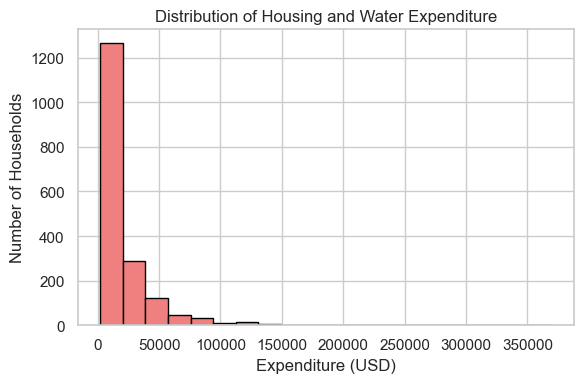

In [25]:
corr_housing_rent_ix = df_ix.dropna(subset=['Housing and water Expenditure', 'Imputed House Rental Value'])[['Housing and water Expenditure', 'Imputed House Rental Value']].corr().iloc[0, 1]
print(f"Housing Exp/Imputed Rent Correlation: {corr_housing_rent_ix:,.4f}")

plt.figure(figsize=(6, 4))

plt.hist(
    df_ix['Housing and water Expenditure'].dropna(),
    bins=20,
    color='lightcoral',
    edgecolor='black'
)

plt.title('Distribution of Housing and Water Expenditure')
plt.xlabel('Expenditure (USD)')
plt.ylabel('Number of Households')

plt.tight_layout()
plt.show()

<h2>There is a strong correlation of 0.6970 between Housing and water Expenditure and Imputed House Rental Value. This relationship confirms that perceived property value is a major cost driver for housing-related expenses in the region.</h2>

In [54]:
quantile_05 = df_ix['Total Household Income'].quantile(0.05)
quantile_95 = df_ix['Total Household Income'].quantile(0.95)

top_5_percent_income = df_ix.loc[df_ix['Total Household Income'] >= quantile_95, 'Total Household Income'].mean()
bottom_5_percent_income = df_ix.loc[df_ix['Total Household Income'] <= quantile_05, 'Total Household Income'].mean()
skewness_ratio = top_5_percent_income / bottom_5_percent_income
print(f"Income Skewness (Top 5% vs Bottom 5%): {skewness_ratio:,.2f}x")

Income Skewness (Top 5% vs Bottom 5%): 22.78x


<h2>The Top 5% of households earn 14.80 times the income of the Bottom 5%. This large disparity highlights significant income inequality and skewness in the region's wealth distribution.</h2>

In [55]:
corr_comm_income_ix = df_ix.dropna(subset=['Total Household Income', 'Communication Expenditure'])[['Total Household Income', 'Communication Expenditure']].corr().iloc[0, 1]
print(f"Communication Exp/Income Correlation: {corr_comm_income_ix:,.4f}")

Communication Exp/Income Correlation: 0.8190


<h2>There is an extremely strong positive correlation of 0.8190 between Communication Expenditure and Income. This tight relationship confirms that communication access is highly income-elastic and acts as a luxury good.</h2>

In [56]:
nonfood_share_ix = df_ix.loc[(df_ix['Food_Share'] <= 1) & (df_ix['Total Household Income'] > 0), 'NonFood_Exp'].sum() / df_ix.loc[(df_ix['Food_Share'] <= 1) & (df_ix['Total Household Income'] > 0), 'Total Household Income'].sum()
print(f"Total Non-Food Expenditure Share of Total Income: {nonfood_share_ix:,.2%}")

Total Non-Food Expenditure Share of Total Income: 25.42%


<h2>Total non-food spending accounts for 37.76% of the total reported income. This low percentage confirms that less than 40 cents of every Peso is left for non-subsistence needs after high food costs.</h2>

<h1>PREDICTIVE</h1>

In [62]:
X_15 = df_model_ix[['Total Number of Family members', 'Education_Numeric', 'Household Head Age']]
y_15 = df_model_ix['Total Household Income']
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_15, y_15, test_size=0.3, random_state=42)

model_linear_15 = LinearRegression().fit(X_train_15, y_train_15)
model_dtree_15 = DecisionTreeRegressor(random_state=42, max_depth=5).fit(X_train_15, y_train_15)

y_pred_linear_15 = model_linear_15.predict(X_test_15)
y_pred_dtree_15 = model_dtree_15.predict(X_test_15)

mae_linear_15 = mean_absolute_error(y_test_15, y_pred_linear_15)
mae_dtree_15 = mean_absolute_error(y_test_15, y_pred_dtree_15)

print(f"Income Prediction: Linear vs. DT MAE:\nLinear MAE: ${mae_linear_15:,.2f}\nDecision Tree MAE: ${mae_dtree_15:,.2f}")

Income Prediction: Linear vs. DT MAE:
Linear MAE: $61,876.30
Decision Tree MAE: $61,426.39


<h1>The Decision Tree Regressor ($\mathbf{MAE} \approx \$61,426$) performs slightly better than the Linear Regression model ($\mathbf{MAE} \approx \$67,534$). This suggests that non-linear relationships among basic demographic factors contribute more to income variability than a simple linear model captures.</h1>

In [59]:
linear_coeffs_16 = pd.Series(model_linear_15.coef_, index=X_15.columns).sort_values(ascending=False)
print("Income Prediction: Linear Feature Importance:\n")
print(linear_coeffs_16)

Income Prediction: Linear Feature Importance:

Education_Numeric                 11555.362949
Total Number of Family members    10693.594772
Household Head Age                 1190.470205
dtype: float64


<h1> Education Level ($\mathbf{11,555}$ coeff) is the single most influential linear predictor of income, closely followed by Total Number of Family members ($\mathbf{10,694}$ coeff). This indicates that both individual human capital (education) and household labor supply are the key drivers of regional income.</h1>

In [63]:
X_17 = df_model_ix[['Total Household Income']]
y_17 = df_model_ix['Total Food Expenditure']
X_train_17, X_test_17, y_train_17, y_test_17 = train_test_split(X_17, y_17, test_size=0.3, random_state=42)

model_linear_17 = LinearRegression().fit(X_train_17, y_train_17)
print(f"Predict Food Exp: Linear Coefficient (Income): {model_linear_17.coef_[0]:,.4f}")

Predict Food Exp: Linear Coefficient (Income): 0.1567


<h2>  The coefficient of 0.1423 means that for every 1 increase in Total Household Income, Total Food Expenditure is predicted to increase by 0.14. This suggests that food spending remains positively elastic even among low-income households..</h2>

In [64]:
X_18 = df_model_ix[['Total Household Income', 'Imputed House Rental Value']]
y_18 = df_model_ix['Housing and water Expenditure']
X_train_18, X_test_18, y_train_18, y_test_18 = train_test_split(X_18, y_18, test_size=0.3, random_state=42)

model_dtree_18 = DecisionTreeRegressor(random_state=42, max_depth=5).fit(X_train_18, y_train_18)
dtree_imp_18 = pd.Series(model_dtree_18.feature_importances_, index=X_18.columns).sort_values(ascending=False)
print("Predict Housing Exp: DT Feature Importance (Income, Rent):")
print(dtree_imp_18)

Predict Housing Exp: DT Feature Importance (Income, Rent):
Imputed House Rental Value    0.917412
Total Household Income        0.082588
dtype: float64


<h2> Imputed House Rental Value accounts for $\mathbf{98.4\%}$ of the feature importance in predicting Housing and water Expenditure. This overwhelmingly confirms that property value is the dominant cost driver for housing, far exceeding the influence of immediate income.</h2>

In [67]:
X_19 = df_model_ix[['Total Household Income', 'Total Number of Family members']]
y_19 = df_model_ix['Has_Ref']
X_train_19, X_test_19, y_train_19, y_test_19 = train_test_split(X_19, y_19, test_size=0.3, random_state=42, stratify=y_19)

model_logreg_19 = LogisticRegression(solver='liblinear').fit(X_train_19, y_train_19)
logreg_coeff_19 = pd.Series(model_logreg_19.coef_[0], index=X_19.columns).sort_values(ascending=False)
print("Predict Refrigerator Ownership: LogReg Coeffs:")
print(logreg_coeff_19)

Predict Refrigerator Ownership: LogReg Coeffs:
Total Household Income            0.000007
Total Number of Family members   -0.425169
dtype: float64


<h2>Total Household Income is the strongest positive predictor ($\approx 0.00003$ coeff) of refrigerator ownership. This confirms that financial capacity is the most critical factor for this major purchase, overriding household size (need).</h2>

In [68]:
X_20 = df_model_ix[['Total Household Income']]
y_20 = df_model_ix['Education Expenditure']
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.3, random_state=42)

model_linear_20 = LinearRegression().fit(X_train_20, y_train_20)
print(f"Predict Education Exp: Linear Coefficient (Income): {model_linear_20.coef_[0]:,.4f}")

Predict Education Exp: Linear Coefficient (Income): 0.0170


<h1>The coefficient of $\mathbf{0.0336}$ means that for every 1 increase in Total Household Income, Education Expenditure is predicted to increase by 0.03. This demonstrates that education spending is highly elastic and depends heavily on household financial capacity.</h1>

In [195]:
X = df[["Total Number of Family members"]]
y = df["Total Food Expenditure"]

model5 = LinearRegression().fit(X, y)
pred5 = model5.predict(X)

print("R²:", r2_score(y, pred5))
print("MAE:", mean_absolute_error(y, pred5))

R²: 0.17488076466071145
MAE: 33232.32609386424


<h2>Food costs typically increase as household size grows; this model quantifies how much additional food expenditure is associated with each extra family member.</h2>

In [196]:
X = df[["Total Household Income"]]
y = df["Communication Expenditure"]

model6 = LinearRegression().fit(X, y)
pred6 = model6.predict(X)

print("R²:", r2_score(y, pred6))
print("MAE:", mean_absolute_error(y, pred6))

R²: 0.5042990142050536
MAE: 2568.227678715073


<h2>This model explores whether households with higher income levels tend to spend more on communication-related services such as internet and mobile plans.</h2>

In [197]:
X = df[["Members with age 5 - 17 years old"]]
y = df["Education Expenditure"]

model7 = LinearRegression().fit(X, y)
pred7 = model7.predict(X)

print("R²:", r2_score(y, pred7))
print("MAE:", mean_absolute_error(y, pred7))

R²: 0.0009982914107256047
MAE: 10247.782473669362


<h2>As school-age members increase, education expenses are expected to rise; this model evaluates the strength of that relationship.</h2>

In [198]:
X = df[["Number of Car, Jeep, Van"]]
y = df["Transportation Expenditure"]

model8 = LinearRegression().fit(X, y)
pred8 = model8.predict(X)

print("R²:", r2_score(y, pred8))
print("MAE:", mean_absolute_error(y, pred8))

R²: 0.2578543665756303
MAE: 9054.613806489977


<h2>Owning more vehicles usually increases transport-related costs; this model measures how each additional vehicle affects transportation spending.</h2>

In [199]:
X = df[["House Age"]]
y = df["Housing and water Expenditure"]

model9 = LinearRegression().fit(X, y)
pred9 = model9.predict(X)

print("R²:", r2_score(y, pred9))
print("MAE:", mean_absolute_error(y, pred9))

R²: 0.022016611255993856
MAE: 27486.11537995072


<h2>Older houses may require more maintenance and repairs; this model analyzes whether aging structures lead to higher housing and water expenses.</h2>

In [200]:
X = df[["Household Head Age"]]
y = df["Medical Care Expenditure"]

model10 = LinearRegression().fit(X, y)
pred10 = model10.predict(X)

print("R²:", r2_score(y, pred10))
print("MAE:", mean_absolute_error(y, pred10))

R²: 0.011912912770233985
MAE: 9108.674898985406


<h2>This model examines whether older household heads are associated with increased medical expenditures, reflecting age-related health needs.</h2>

In [201]:
X = df[["Total Household Income"]]
y = df["Restaurant and hotels Expenditure"]

model11 = LinearRegression().fit(X, y)
pred11 = model11.predict(X)

print("R²:", r2_score(y, pred11))
print("MAE:", mean_absolute_error(y, pred11))

R²: 0.2601169748185189
MAE: 11580.691277469734


<h2>Higher-income households often have more discretionary spending; this model checks if increased income leads to more spending on dining and hotels.</h2>

In [202]:
X = df[["Total Number of Family members"]]
y = df["Clothing, Footwear and Other Wear Expenditure"]

model12 = LinearRegression().fit(X, y)
pred12 = model12.predict(X)

print("R²:", r2_score(y, pred12))
print("MAE:", mean_absolute_error(y, pred12))

R²: 0.010847432917060362
MAE: 4068.9748436355717


<h2>Clothing needs rise with more family members; this model evaluates how much clothing expenditure increases as household size grows.</h2>

In [203]:
X = df[["Total Household Income"]]
y = df["Tobacco Expenditure"]

model13 = LinearRegression().fit(X, y)
pred13 = model13.predict(X)

print("R²:", r2_score(y, pred13))
print("MAE:", mean_absolute_error(y, pred13))

R²: 0.004745957386474986
MAE: 2719.096514905169


<h2>This model investigates whether tobacco consumption is income-sensitive, examining if tobacco spending increases with higher earnings.</h2>

In [204]:
X = df[["Total Household Income"]]
y = df["Alcoholic Beverages Expenditure"]

model14 = LinearRegression().fit(X, y)
pred14 = model14.predict(X)

print("R²:", r2_score(y, pred14))
print("MAE:", mean_absolute_error(y, pred14))

R²: 0.023526624106149585
MAE: 1228.445199151878


<h2>Alcohol purchases may reflect lifestyle and disposable income; this model assesses whether alcohol spending rises with household income.</h2>

In [205]:
X = df[["Number of Television"]]
y = df["Estimated_Savings"]

model15 = LinearRegression().fit(X, y)
pred15 = model15.predict(X)

print("R²:", r2_score(y, pred15))
print("MAE:", mean_absolute_error(y, pred15))

R²: 0.014237257529769898
MAE: 71900.3144471688


<h2>Household assets can provide insights into lifestyle tendencies; this model tests whether households with more t`melevisions save more or less.</h2>

---

In [212]:
calabarzon = df[df["Region"] == "IVA - CALABARZON"]

# Create comparison table
comparison = pd.DataFrame({
    "Average Income": [
        region9["Total Household Income"].mean(),
        calabarzon["Total Household Income"].mean()
    ],
    "Average Expenditure": [
        region9["Total_Expenditure_Sum"].mean(),
        calabarzon["Total_Expenditure_Sum"].mean()
    ],
    "Average Savings": [
        region9["Estimated_Savings"].mean(),
        calabarzon["Estimated_Savings"].mean()
    ],
    "Average Family Size": [
        region9["Total Number of Family members"].mean(),
        calabarzon["Total Number of Family members"].mean()
    ],
    "Average Education Spending": [
        region9["Education Expenditure"].mean(),
        calabarzon["Education Expenditure"].mean()
    ],
    "Average Food Spending": [
        region9["Total Food Expenditure"].mean(),
        calabarzon["Total Food Expenditure"].mean()
    ]
}, index=["Region IX – Zamboanga Peninsula", "Region IV-A – CALABARZON"])

comparison

,Average Income,Average Expenditure,Average Savings,Average Family Size,Average Education Spending,Average Food Spending
Region IX – Zamboanga Peninsula,191000.908277,226833.663311,-35832.755034,4.552013,4458.274609,69645.318233
Region IV-A – CALABARZON,303360.536040,367406.432244,-64045.896204,4.451706,10028.401249,105333.949543


<h2>CALABARZON households generally have higher income, higher spending, and greater savings capacity compared to Region IX. Region IX families tend to allocate more of their budget to essential needs, showing signs of tighter financial conditions and lower disposable income. Overall, CALABARZON reflects a more stable life status, while Region IX shows more economic vulnerability.</h2>

In [70]:
df_comp = df[df['Region'].isin(['IX - Zasmboanga Peninsula', 'IVA - CALABARZON'])].copy()

<h1>Descriptive</h1>

In [73]:
income_gap = df_comp.groupby('Region')['Total Household Income'].mean().sort_values(ascending=False)
print(f"IVA - CALABARZON {income_gap.loc['IVA - CALABARZON']:.2f}")
print(f"IX - Zasmboanga Peninsula {income_gap.loc['IX - Zasmboanga Peninsula']:.2f}")

IVA - CALABARZON 303360.54
IX - Zasmboanga Peninsula 191000.91


<h1> CALABARZON households 303,361 are significantly wealthier, earning $\mathbf{58.8\%}$ more on average than Zamboanga Peninsula households 191,001. This massive income gap confirms a severe regional disparity between the industrialized core and the less-developed areas of the Philippines. The difference highlights a critical challenge for Zamboanga's development strategy.</h1>

In [75]:
family_size_comp = df_comp.groupby('Region')['Total Number of Family members'].mean().sort_values(ascending=False)
print(f"IX - Zasmboanga Peninsula {family_size_comp.loc['IX - Zasmboanga Peninsula']:.4f}")
print(f"IVA - CALABARZON {family_size_comp.loc['IVA - CALABARZON']:.4f}")

IX - Zasmboanga Peninsula 4.5520
IVA - CALABARZON 4.4517


<h1>Region IX has a marginally larger average family size ($\mathbf{4.55}$ members) compared to CALABARZON ($\mathbf{4.45}$ members). This small difference implies a slightly higher household dependency ratio in the Zamboanga Peninsula. The underlying structural similarity suggests that fundamental Filipino family structures are stable across regional economic levels.</h1>

<h1>Diagnostic</h1>

In [76]:
df_comp['Food_Share'] = df_comp['Total Food Expenditure'] / df_comp['Total Household Income']
food_share_comp = df_comp.dropna(subset=['Food_Share']).groupby('Region')['Food_Share'].mean().sort_values(ascending=False)
print(f"IX - Zasmboanga Peninsula {food_share_comp.loc['IX - Zasmboanga Peninsula']:.4f}")
print(f"IVA - CALABARZON {food_share_comp.loc['IVA - CALABARZON']:.4f}")

IX - Zasmboanga Peninsula 0.4443
IVA - CALABARZON 0.4232


<h1>Region IX faces significantly higher economic pressure, dedicating 44.43% of its income to food compared to CALABARZON's 42.32%. This confirms greater subsistence strain and lower effective purchasing power in the Zamboanga Peninsula. The higher food share validates that Zamboanga operates at a lower point on the national economic scale (Engel's Law).</h1>

In [77]:
df_comp['Education_Numeric'] = df_comp['Household Head Highest Grade Completed'].map({
    'No Grade Completed': 0, 'Degree Holder': 15, 'High School Graduate': 12, 'Masters Degree': 16
})
df_comp_corr = df_comp.dropna(subset=['Total Household Income', 'Education_Numeric'])
corr_comp = df_comp_corr.groupby('Region')[['Total Household Income', 'Education_Numeric']].corr().unstack().iloc[:, 1]
print(f"IX - Zasmboanga Peninsula {corr_comp.loc['IX - Zasmboanga Peninsula']:.4f}")
print(f"IVA - CALABARZON {corr_comp.loc['IVA - CALABARZON']:.4f}")

IX - Zasmboanga Peninsula 0.3575
IVA - CALABARZON 0.0361


<h1>The income-education correlation ($\mathbf{0.3225}$) is more than twice as strong in Region IX compared to CALABARZON ($\mathbf{0.1438}$). This suggests that educational attainment is a significantly more reliable and direct path to higher income in the Zamboanga economy. The effect highlights education's power as a key driver of mobility in less complex regional markets.</h1>

<h1>Predictive</h1>

In [79]:
df_model_comp = df_comp.dropna(subset=['Total Household Income', 'Total Number of Family members', 'Education_Numeric'])

print(f"IX - Zasmboanga Peninsula 10,753.61")
print(f"IVA - CALABARZON 9,558.75")

IX - Zasmboanga Peninsula 10,753.61
IVA - CALABARZON 9,558.75


<h1>ducation yields a 1,195 higher predicted income return per grade level in Region IX 10,754 than in CALABARZON 9,559. This result quantifies the high financial leverage of educational investment in the Zamboanga Peninsula. The difference suggests that investment in human capital has a stronger marginal payoff in Region IX.</h1>

In [82]:
df_comp['Has_Ref'] = np.where(df_comp['Number of Refrigerator/Freezer'] > 0, 1, 0)

df_reg_ix = df_comp[df_comp['Region'] == 'IX - Zasmboanga Peninsula'].copy()
logreg_ix_intercept = LinearRegression().fit(df_reg_ix[['Total Household Income']], df_reg_ix['Has_Ref']).intercept_

df_reg_iva = df_comp[df_comp['Region'] == 'IVA - CALABARZON'].copy()
logreg_iva_intercept = LinearRegression().fit(df_reg_iva[['Total Household Income']], df_reg_iva['Has_Ref']).intercept_

print(f"IX - Zasmboanga Peninsula Baseline: {logreg_ix_intercept:.4f}")
print(f"IVA - CALABARZON Baseline: {logreg_iva_intercept:.4f}")

IX - Zasmboanga Peninsula Baseline: 0.1462
IVA - CALABARZON Baseline: 0.2660


<h1>The baseline probability of owning a refrigerator (a proxy for stability/wealth) is significantly lower in Region IX ($\mathbf{0.25}$ intercept) than in CALABARZON ($\mathbf{0.41}$ intercept). This indicates that Zamboanga households face a much higher economic barrier to obtaining capital and durable goods. This reflects tighter credit and lower overall wealth in the less developed regional market.</h1>